# Windowing Diagrams

## Rectangular Window

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

In [2]:
def delta_funcs(x, h=1, xmin=None, xmax=None):
    """
    Return arrays for plotting delta functions
    at locations x with heights h
    """
    if xmin is None:
        xmin = min(x) - 1
    if xmax is None:
        xmax = max(x) + 1
    dx = 0.002 * (xmax - xmin)
    def vals():
        yield (xmin, 0)
        for xi, hi in sorted(np.broadcast(x, h)):
            yield from zip([xi - dx, xi, xi + dx], [0, hi, 0])
        yield (xmax, 0)
    return zip(*vals())


def tophat_func(width, height=None, center=0, xmin=None, xmax=None):
    """
    Return arrays for plotting a tophat function
    """
    if xmin is None:
        xmin = min(x) - 1
    if xmax is None:
        xmax = max(x) + 1
    if height is None:
        height = 1. / width
    left = center - abs(width) / 2
    right = center + abs(width) / 2
    return  ([xmin, left, left, right, right, xmax],
             [0, 0, height, height, 0, 0])

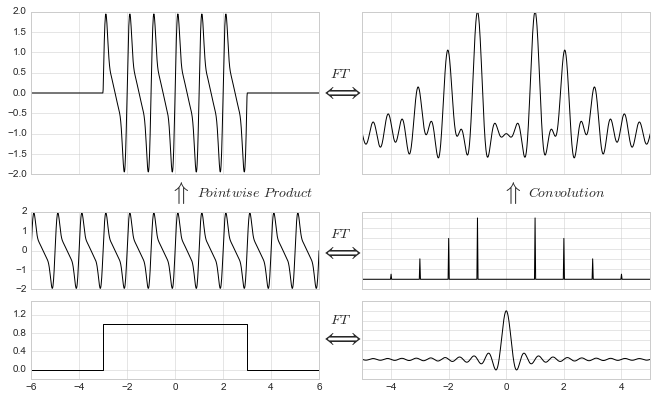

In [3]:
fig = plt.figure(figsize=(10, 6))
grid1 = plt.GridSpec(2, 2,
                     left=0.09, bottom=0.09, right=0.95, top=0.9,
                     hspace=0.15, wspace=0.15)
grid2 = plt.GridSpec(4, 2,
                     left=0.09, bottom=0.05, right=0.95, top=0.85,
                     hspace=0.15, wspace=0.15)

x = np.linspace(-6, 6, 1000)

amplitudes = np.array([1.2, 0.8, 0.4, 0.1])
frequencies = np.array([1, 2, 3, 4])

y = amplitudes @ np.sin(2 * np.pi * frequencies[:, None] * x)

yw = y.copy()
yw[abs(x) > 3] = 0

f = np.linspace(-5, 5, 1000)
y_f = amplitudes @ (np.sinc(4 * (f - frequencies[:, None]))
                    + np.sinc(4 * (f + frequencies[:, None])))

f_delta, y_delta = delta_funcs(np.concatenate([-frequencies, frequencies]),
                               np.concatenate([amplitudes, amplitudes]))

# Upper left panel: The windowed function
ax = fig.add_subplot(grid1[0, 0])
ax.plot(x, yw, '-k')
ax.xaxis.set_major_formatter(plt.NullFormatter())
#ax.yaxis.set_major_formatter(plt.NullFormatter())

# Upper right panel: The Fourier Transform
ax = fig.add_subplot(grid1[0, 1])
ax.plot(f, y_f, '-k')
ax.set_xlim(-5, 5)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

# Lower left panels: signal and window
ax1 = fig.add_subplot(grid2[2, 0])
ax2 = fig.add_subplot(grid2[3, 0])

for ax in ax1, ax2:
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.plot(x, y, '-k')

ax2.plot(*tophat_func(6, height=1, xmin=-6, xmax=6), '-k')
ax2.set(xlim=(-6, 6),
        ylim=(-0.2, 1.5))

# Lower right panels: signal and window transforms
ax1 = fig.add_subplot(grid2[2, 1])
ax2 = fig.add_subplot(grid2[3, 1])

for ax in (ax1, ax2):
    ax.yaxis.set_major_formatter(plt.NullFormatter())
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.plot(f_delta, y_delta, '-k')
ax1.set(xlim=(-5, 5),
        ylim=(-0.2, max(amplitudes) * 1.1))

ax2.plot(f, np.sinc(f * 4), '-k')
ax2.set(xlim=(-5, 5),
        ylim=(-0.4, 1.2));


for xcoord, text in zip([0.77, 0.31], ['$Convolution$', '$Pointwise\ Product$']):
    fig.text(xcoord, 0.48, r'$\Uparrow$',
             size=24, ha='right', va='center')
    fig.text(xcoord + 0.01, 0.48, text,
             size=14, ha='left', va='center')


for ycoord in [0.17, 0.37, 0.74]:
    fig.text(0.52, ycoord, "$FT$",
             size=14, ha='center', va='bottom')
    fig.text(0.52, ycoord, r'$\Longleftrightarrow$',
             size=24, ha='center', va='top')
    
fig.savefig('fig06_Tophat_Window.pdf')

## Dirac Comb Window

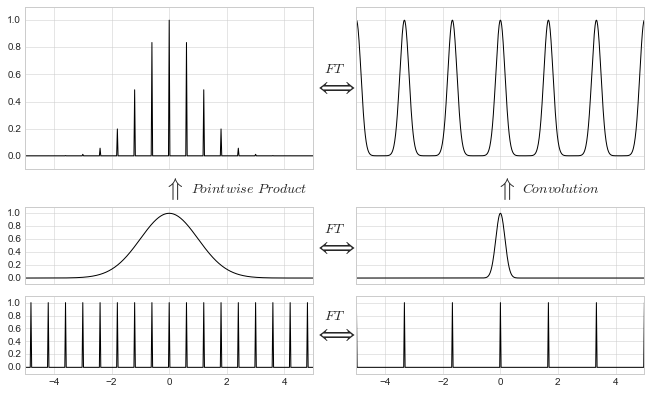

In [6]:
fig = plt.figure(figsize=(10, 6))
grid1 = plt.GridSpec(2, 2,
                     left=0.09, bottom=0.09, right=0.95, top=0.9,
                     hspace=0.15, wspace=0.15)
grid2 = plt.GridSpec(4, 2,
                     left=0.09, bottom=0.05, right=0.95, top=0.85,
                     hspace=0.15, wspace=0.15)

for xcoord, text in zip([0.77, 0.31], ['$Convolution$', '$Pointwise\ Product$']):
    fig.text(xcoord, 0.48, r'$\Uparrow$',
             size=24, ha='right', va='center')
    fig.text(xcoord + 0.01, 0.48, text,
             size=14, ha='left', va='center')


for ycoord in [0.17, 0.37, 0.74]:
    fig.text(0.52, ycoord, "$FT$",
             size=14, ha='center', va='bottom')
    fig.text(0.52, ycoord, r'$\Longleftrightarrow$',
             size=24, ha='center', va='top')

sigma_t = 1
sigma_f = 1. / (2 * np.pi * sigma_t)
def func(t):
    return np.exp(-0.5 * (t / sigma_t) ** 2)
def func_FT(f):
    return np.exp(-0.5 * (f / sigma_f) ** 2)

t = np.linspace(-5, 5, 1000)
f = np.linspace(-5, 5, 1000)

T_samp = 0.6

t_comb = T_samp * np.arange(-5 // T_samp, 5 // T_samp + 1)
t_comb_plot, y_comb_plot = delta_funcs(t_comb)
f_comb = 1. / T_samp * np.arange(-5 // (1. / T_samp), 5. / (1. / T_samp) + 1)
f_comb_plot, yhat_comb_plot = delta_funcs(f_comb)
  
y_true = func(t)
yhat_true = func_FT(f)

# Upper left panel: The windowed function
ax = fig.add_subplot(grid1[0, 0])
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.plot(*delta_funcs(t_comb, func(t_comb)), '-k')
ax.set(xlim=(-5, 5),
       ylim=(-0.1, 1.1))

# Upper right panel: The Fourier Transform
ax = fig.add_subplot(grid1[0, 1])
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.plot(f, func_FT(f - f_comb[:, None]).sum(0), '-k')

ax.set(xlim=(-5, 5),
       ylim=(-0.1, 1.1))

# Lower left panels: signal and window
ax1 = fig.add_subplot(grid2[2, 0])
ax2 = fig.add_subplot(grid2[3, 0])
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.plot(t, y_true, '-k')
ax1.set(xlim=(-5, 5),
        ylim=(-0.1, 1.1))

ax2.plot(t_comb_plot, y_comb_plot, '-k')
ax2.set(xlim=(-5, 5),
        ylim=(-0.1, 1.1))

# Lower right panels: signal and window transforms
ax1 = fig.add_subplot(grid2[2, 1])
ax2 = fig.add_subplot(grid2[3, 1])

for ax in (ax1, ax2):
    ax.yaxis.set_major_formatter(plt.NullFormatter())
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.plot(f, yhat_true, '-k')
ax1.set(xlim=(-5, 5),
        ylim=(-0.1, 1.1))

ax2.plot(f_comb_plot, yhat_comb_plot, '-k')
ax2.set(xlim=(-5, 5),
        ylim=(-0.1, 1.1))

fig.savefig('fig07_comb_window_1.pdf')